In [1]:
### Header

# 3 - Modeling pipelines

In [2]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, GridSearchCV
import time
import joblib


In [ ]:
SEED = 123
np.random.seed(SEED) # to have reproducible results

RANDOM_STATE = 42

In [3]:
# Read preprocessed data file
data = pd.read_csv("../data/ctg_pp_02.csv")
data_copy = data.copy() # create checkpoint
data.head()

,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,...,Width,Min,Max,Nmax,Nzeros,Median,Variance,Tendency,CLASS,NSP
0,120.0,0.0,0.0,0.0,73.0,0.5,43.0,2.4,0.0,0.0,...,64.0,62.0,126.0,2.0,0,121.0,73.0,2,8,1
1,132.0,4.0,0.0,4.0,17.0,2.1,0.0,10.4,2.0,0.0,...,130.0,68.0,198.0,6.0,1,140.0,12.0,1,5,0
2,133.0,2.0,0.0,5.0,16.0,2.1,0.0,13.4,2.0,0.0,...,130.0,68.0,198.0,5.0,1,138.0,13.0,1,5,0
3,134.0,2.0,0.0,6.0,16.0,2.4,0.0,23.0,2.0,0.0,...,117.0,53.0,170.0,11.0,0,137.0,13.0,2,5,0
4,132.0,4.0,0.0,5.0,16.0,2.4,0.0,19.9,0.0,0.0,...,117.0,53.0,170.0,9.0,0,138.0,11.0,2,1,0


### 3.1 - Train-test split

In [5]:
# We separate target from features
X = data.drop(columns = ["CLASS", "NSP"], axis=1)
y1 = data["CLASS"]
y2 = data["NSP"]

In [6]:
# Dataset 1: non-normalized dataset with classifier CLASS (1 to 10)
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.3, random_state=RANDOM_STATE)
ds_raw_class = [X_train, X_test, y1_train, y1_test]

[X_train.shape, X_test.shape, y1_train.shape, y1_test.shape]

[(1488, 19), (638, 19), (1488,), (638,)]

In [7]:
# Dataset 2: non-normalized dataset with classifier NSP (1 to 3)
# Since random_state is the same, the split will be the same and we can overwrite X_train and X_test
X_train, X_test, y2_train, y2_test = train_test_split(X, y2, test_size=0.3, random_state=RANDOM_STATE)
ds_raw_nsp = [X_train, X_test, y2_train, y2_test]

[X_train.shape, X_test.shape, y2_train.shape, y2_test.shape]

[(1488, 19), (638, 19), (1488,), (638,)]

### 3.2 - Standardization

In [9]:
scaler = StandardScaler()

# We do the standardization on the training set, and we use the means and stdevs of the training set to standardize the training set
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns) # We turn it from np array to pd dataframe
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns) # We turn it from np array to pd dataframe

X_train_scaled.head()

,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,DP,Width,Min,Max,Nmax,Nzeros,Median,Variance,Tendency
0,-0.206477,1.473809,-0.198745,-0.605278,0.431726,0.186101,-0.52269,-0.512725,-0.219452,-0.063628,-0.27779,0.399489,-0.350816,0.288419,1.007014,-0.473891,0.621293,0.096860,1.122236
1,0.899419,-0.774298,-0.198745,0.093987,-0.146655,-0.610295,-0.46668,0.509125,-0.624594,-0.063628,-0.27779,-0.992703,1.102038,-0.332173,-1.023847,-0.473891,0.621293,-0.580749,-0.519737
2,0.396739,-0.212271,-0.198745,0.793253,-1.129903,0.299872,-0.52269,0.332944,1.401117,-0.063628,-0.27779,0.270583,-0.249454,0.175584,-0.685370,-0.473891,0.213132,0.130740,1.122236
3,0.497275,-0.774298,-0.095514,-0.954911,0.489564,-0.724065,-0.52269,0.191999,-0.219452,-0.063628,-0.27779,-0.580201,0.324930,-0.727095,-0.008416,-0.473891,0.349186,-0.479108,1.122236
4,-0.407549,-0.493284,-0.043898,-1.304544,0.026859,-0.496524,-0.52269,1.601447,-0.624594,-0.063628,-0.27779,0.863554,-1.398222,-0.445008,0.668537,-0.473891,-0.263055,-0.512988,1.122236


In [11]:
# With these two we have our 4 datasets to test
ds_std_class = [X_train_scaled, X_test_scaled, y1_train, y1_test]
ds_std_nsp = [X_train_scaled, X_test_scaled, y2_train, y2_test]

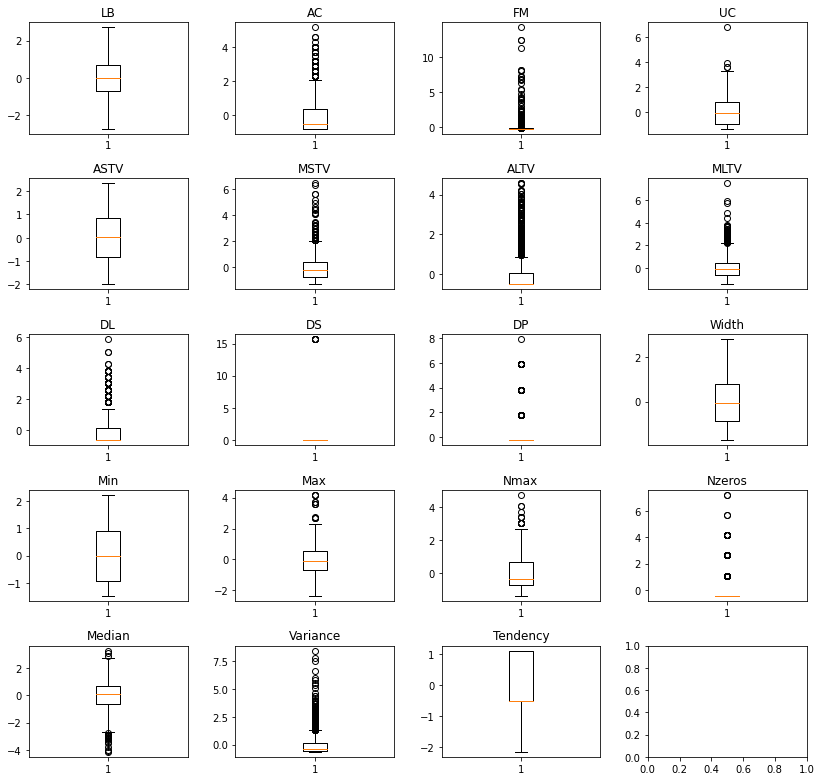

In [12]:
# Check standardisation with boxplots
# Can see that the mean is 0? Good. (Note that boxplots show the median not mean)

fig, axs = plt.subplots(5, 4, figsize = (12, 12))
axs = axs.flatten()

for col_name, ax in zip(X_train_scaled, axs):
    ax.boxplot(X_train_scaled[col_name])
    ax.set_title(col_name)

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)

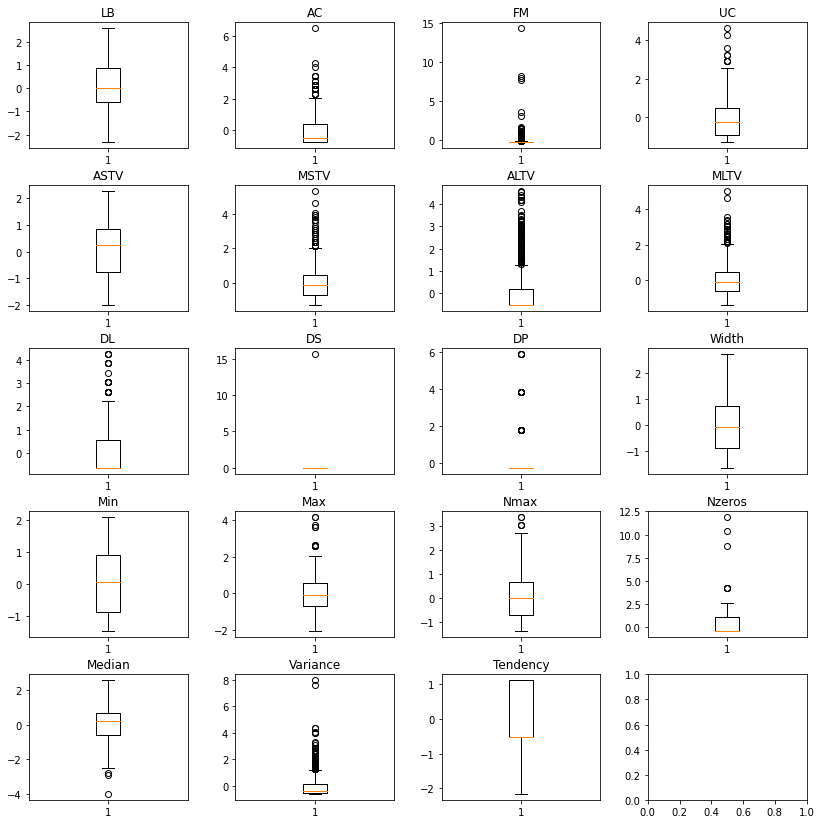

In [13]:
# Check standardisation of X_test with boxplots
fig, axs = plt.subplots(5, 4, figsize = (12, 12))
axs = axs.flatten()

for col_name, ax in zip(X_test_scaled, axs):
    ax.boxplot(X_test_scaled[col_name])
    ax.set_title(col_name)

fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95,
                    hspace=0.3, wspace=0.3)

### 3.3 - Modeling pipelines: random search first approximation

We will train the following algorithms, tuning the appropiate hyperparameters for each:

- Logistic Regression (LG) 
- k-Nearest Neighbors (kNN)
- Support Vector Machine Classifier (SVM)
- Decision Tree (DT)
- Random Forest (RF)

Given the number models to train, with their respective hyperparameters, plus the number of datasets to train (4), we will adopt a **RandomizedSearch strategy**. Contrary to GridSearch, in which every combination of paramater values are tried, RandomSearch sets up a grid of parameters and selects random combinations to train the model and score.

To evaluate the output models, we will use the **F1 score** which is the harmonic mean of the precision and recall. Where precision is the proportion of relevant instances correctly classified (true positives/(true positives+false positives)) and recall is the proportion of the total amount of relevant instances correctly classified (true positives/(true postitives+false negatives)). F1 score reaches its best value at 1 (perfect precision and recall). 

Because we are dealing with multi-class classification, we have three measures of F1 score, macro, averaged and micro. We will be using the **macro-averaged F1 score**, which uses the arithmetic mean of all the per-class F1 scores.

In [15]:
# Random search parameters
param_range_1 = [0.001,0.01,0.1,1,10,100] # cost
param_range_2 = np.arange(2, 20) # n_neigghbors, max_dexpth, min_samples_leaf, min_samples_split 

grid_params_lr = [{'penalty': ['l1'],
                   'C': param_range_1,
                   'solver': ['liblinear', 'saga'], 
                    "max_iter": [10000]},
                  {'penalty': ['l2'],
                   'C': param_range_1,
                   'solver': ['liblinear', 'saga']}, 
                  {'penalty': ['l2'],
                   'C': param_range_1,
                   'solver': ['lbfgs']}]
grid_params_knn = [{'n_neighbors': param_range_2}]
grid_params_svm = [{'kernel': ['linear', 'rbf'],
                    'gamma': ['auto','scale'],
                    'C': param_range_1}]
grid_params_dt = [{'criterion': ['gini', 'entropy'],
                   'splitter': ['best','random'],
                   'min_samples_leaf': param_range_2,
                   'max_depth': param_range_2, 
                   'min_samples_split': param_range_2}]
grid_params_rf = [{'criterion': ['gini', 'entropy'],              
                   'min_samples_leaf': param_range_2, 
                   'max_depth': param_range_2, 
                   'min_samples_split': param_range_2}]             

In [15]:
# Build grid searches
kfold = StratifiedKFold(n_splits=5, shuffle=True)
gs_lr = RandomizedSearchCV(estimator=LogisticRegression(n_jobs = -1), 
                           param_distributions=grid_params_lr,
                           scoring='f1_macro',
                           cv=kfold) 
gs_knn = RandomizedSearchCV(estimator=KNeighborsClassifier(n_jobs = -1),
                            param_distributions=grid_params_knn,
                            scoring='f1_macro',
                            cv=kfold)
gs_svm = RandomizedSearchCV(estimator=svm.SVC(),
                            param_distributions=grid_params_svm,
                            scoring='f1_macro',
                            cv=kfold)
gs_dt = RandomizedSearchCV(estimator=DecisionTreeClassifier(),
                           param_distributions=grid_params_dt,
                           scoring='f1_macro',
                           cv=kfold) 
gs_rf = RandomizedSearchCV(estimator=RandomForestClassifier(n_jobs = -1),
                           param_distributions=grid_params_rf,
                           scoring='f1_macro',
                           cv=kfold) 

In [16]:
# To silence the warnings, we will shuffle from active to inactive at different times
# DOES NOT work with the n_jobs = -1 setting
#import warnings
#from warnings import simplefilter
#warnings.filterwarnings('ignore')

# Solution found over here: https://stackoverflow.com/questions/53784971/how-to-disable-convergencewarning-using-sklearn/55595680#55595680
import sys
import os
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

In [51]:
# We will iterate over the datasets and grid setups with different models
# It takes aprox 30 min to run
# Would be nice to save the result of each grid search to file, not printed because it was overwhelming

datasets_dict = {"raw_CLASS": ds_raw_class, 
                 "std_CLASS": ds_std_class, 
                 "raw_NSP": ds_raw_nsp, 
                 "std_NSP": ds_std_nsp}

grids_dict = {'Logistic Regression': gs_lr, 
              'k-Nearest Neighbors': gs_knn, 
              'Support Vector Machine': gs_svm, 
              'Decision Tree': gs_dt, 
              'Random Forest': gs_rf}

# Fit the grid search objects
# We want to obtain the best model for each dataset
start = time.time()
best_model_ds = dict()

for ds in datasets_dict:
    print(f"\nDataset:{ds}\n")

    best_score = 0.0
    best_model = ""
    best_params = ""
    X_train, X_test, y_train, y_test = datasets_dict[ds][0], datasets_dict[ds][1], datasets_dict[ds][2], datasets_dict[ds][3]

    for model in grids_dict:
        print(f"Estimator: {model}")

        for n in range(1, 5):
            # Fit grid search
            grids_dict[model].fit(X_train, y_train)
            # Predict on test data with best params and get score
            y_pred = grids_dict[model].predict(X_test)
            f1_macro = f1_score(y_test, y_pred, average='macro')

            # Print and save best model&params for each dataset
            if f1_macro > best_score:
                best_model = grids_dict[model]
                best_model_name = model
                best_params = grids_dict[model].best_params_
                best_score = f1_macro
    
    print(f"\nClassifier with best test set F1 score for {ds}:\n{best_model_name}\nparams: {best_params}\nf1 score: {f1_macro}")
    best_model_ds[ds] = {"model": best_model, "params": best_params, "f1": f1_macro, "name": best_model_name}
    
end = time.time()
print('\nTotal execution time:', ((end - start)/60), 'min')


Dataset:raw_CLASS

Estimator: Logistic Regression
Estimator: k-Nearest Neighbors
Estimator: Support Vector Machine
Estimator: Decision Tree
Estimator: Random Forest

Classifier with best test set F1 score for raw_CLASS:
Random Forest
params: {'min_samples_split': 4, 'min_samples_leaf': 5, 'max_depth': 10, 'criterion': 'entropy'}
f1 score: 0.8034678579321437

Dataset:std_CLASS

Estimator: Logistic Regression
Estimator: k-Nearest Neighbors
Estimator: Support Vector Machine
Estimator: Decision Tree
Estimator: Random Forest

Classifier with best test set F1 score for std_CLASS:
Random Forest
params: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 9, 'criterion': 'entropy'}
f1 score: 0.8164829990038424

Dataset:raw_NSP

Estimator: Logistic Regression
Estimator: k-Nearest Neighbors
Estimator: Support Vector Machine
Estimator: Decision Tree
Estimator: Random Forest

Classifier with best test set F1 score for raw_NSP:
Random Forest
params: {'min_samples_split': 7, 'min_samples_le

In [53]:
# save the models dictionary to disk
joblib.dump(best_model_ds, "fitted_random_grids.sav")

# should we need to load it:
#loaded_model = joblib.load("fitted_random_grids.sav")

['fitted_grids_dict.sav']

In [60]:
#best_model_ds

As we can see, in the datasets where the classifier is CLASS, the best algorithm is a **Random Forest**, although **SVC** comes very close. 
In the datasets where the classifier is NSP, the best algorithm is always the **Random Forest Classifier**.

### 3.4 - Grid search strategy to refine the Random Forest Classifier

Next, we will perform a grid search, where unlike in the random search, all combinations of hyperparameters will be tested. Since this is exhaustive and to reduce the running time, we will only test the Random Forest Classifier. Since the difference between normalized and non-normalized subsets is marginal, we will keep all four for now.

In [18]:
#### CAUTION: This takes 3 hours to run. Do not re-run unless strictly necessary.

# Set grid search parameters
param_range_2 = np.arange(2, 20) # n_neigghbors, max_dexpth, min_samples_leaf, min_samples_split

grid_params_dummy = [{'strategy': ['most_frequent']}]
grid_params_rf = [{'criterion': ['entropy'],              
                   'min_samples_leaf': param_range_2, 
                   'max_depth': param_range_2, 
                   'min_samples_split': param_range_2}]            

# Built grid searches
kfold = StratifiedKFold(n_splits=5, shuffle = True)
gs_dummy = GridSearchCV(estimator= DummyClassifier(),
                     param_grid=grid_params_dummy,
                     scoring='f1_macro',
                     cv=kfold) 
gs_rf = GridSearchCV(estimator=RandomForestClassifier(),
                     param_grid=grid_params_rf,
                     scoring='f1_macro',
                     cv=kfold) 

# Datasets and grids dictionaries that we will iterate over
datasets_dict = {"raw_CLASS": ds_raw_class, 
                 "std_CLASS": ds_std_class, 
                 "raw_NSP": ds_raw_nsp, 
                 "std_NSP": ds_std_nsp}

grids_dict = {"Dummy classifier": gs_dummy, 
              'Random Forest': gs_rf}

start = time.time()
best_model_ds_second = dict()

# Fit the grid search objects
for ds in datasets_dict:
    print(f"\nDataset:{ds}\n")

    best_score = 0.0
    best_model = ""
    best_params = ""
    X_train, X_test, y_train, y_test = datasets_dict[ds][0], datasets_dict[ds][1], datasets_dict[ds][2], datasets_dict[ds][3]

    for model in grids_dict:
        print(f"Estimator: {model}")
        # Fit grid search
        grids_dict[model].fit(X_train, y_train)
        # Predict on test data with best params and get score
        y_pred = grids_dict[model].predict(X_test)
        f1_macro = f1_score(y_test, y_pred, average='macro')

        # Print and save best model&params for each dataset
        if f1_macro > best_score:
            best_model = grids_dict[model]
            best_model_name = model
            best_params = grids_dict[model].best_params_
            best_score = f1_macro
    
    print(f"\nClassifier with best test set F1 score for {ds}:\n{best_model_name}\nparams: {best_params}\nf1 score: {f1_macro}")
    best_model_ds_second[ds] = {"model": best_model, "params": best_params, "f1": f1_macro, "name": best_model_name}
    
end = time.time()
print('\nTotal execution time:', ((end - start)/60), 'min')


Dataset:raw_CLASS

Estimator: Dummy classifier
Estimator: Random Forest

Classifier with best test set F1 score for raw_CLASS:
Random Forest
params: {'criterion': 'entropy', 'max_depth': 18, 'min_samples_leaf': 2, 'min_samples_split': 4}
f1 score: 0.8550288686215227

Dataset:std_CLASS

Estimator: Dummy classifier
Estimator: Random Forest

Classifier with best test set F1 score for std_CLASS:
Random Forest
params: {'criterion': 'entropy', 'max_depth': 18, 'min_samples_leaf': 2, 'min_samples_split': 6}
f1 score: 0.8435214556240233

Dataset:raw_NSP

Estimator: Dummy classifier
Estimator: Random Forest

Classifier with best test set F1 score for raw_NSP:
Random Forest
params: {'criterion': 'entropy', 'max_depth': 14, 'min_samples_leaf': 3, 'min_samples_split': 2}
f1 score: 0.9220860402295002

Dataset:std_NSP

Estimator: Dummy classifier
Estimator: Random Forest

Classifier with best test set F1 score for std_NSP:
Random Forest
params: {'criterion': 'entropy', 'max_depth': 14, 'min_samples

In [19]:
# save the second models dictionary to disk
joblib.dump(best_model_ds_second, "fitted_grids.sav")

# should we need to load it:
#loaded_model = joblib.load("fitted_grids_dict.sav")

['fitted_grids.sav']

By the end of this script we have obtained the best hyperparameters for our Random Forest Classification models. We have saved the model objects in a dictionary called "fitted_grids.sav" that we can read in the next step of our pipeline, where we will take a look at model performance and interpretation.